# Test Using data with ksize 5, different sigma
## 2 layers

In [1]:
import time, cv2, os, sys
sys.path.append('..')
import numpy as np
import tensorflow as tf
from deblur_TwoLayer import *
from utils import *
from matplotlib import pyplot as plt
tf.set_random_seed(777)

In [2]:
tmp = np.load('/data1/jerry/project/deblurring/data/diff_sig/data_128_medium_5_shuffle.npz')

img = np.reshape(tmp['data'], [-1, 128,128,1])
lab = np.reshape(tmp['label'], [-1, 128,128])

tr_idx = []
te_idx = []
cnt = []
for i, d in enumerate(img):
    tmp = (d!=0).sum()
    if tmp > 16382 : 
        cnt.append(tmp)
        tr_idx.append(i)
    else : te_idx.append(i)
tr_idx = np.array(tr_idx)
te_idx = np.array(te_idx)

tr_img = img[tr_idx]
tr_lab = lab[tr_idx]

te_img = img[te_idx]
te_lab = lab[te_idx]

print('Train Image Size : %s'%str(tr_img.shape))
print('Train Label Size : %s'%str(tr_lab.shape))

print('Test Image Size : %s'%str(te_img.shape))
print('Test Label Size : %s'%str(te_lab.shape))

Train Image Size : (496, 128, 128, 1)
Train Label Size : (496, 128, 128)
Test Image Size : (3092, 128, 128, 1)
Test Label Size : (3092, 128, 128)


In [3]:
sess = tf.Session()
deblur = Model(sess, "deblur", 128, 3, 1e-3)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
checkpoint = '/data1/jerry/project/deblurring/checkpoint/deblurring03/locally02'
if os.path.exists(checkpoint + '.index'):
    saver.restore(sess, checkpoint)
    print("Restored")
else :
    print("Initializatin Done")

INFO:tensorflow:Restoring parameters from /data1/jerry/project/deblurring/checkpoint/deblurring03/locally02
Restored


In [ ]:
val_tr_cost = []
val_te_cost = []

In [ ]:
start = time.time()
epochs = 10000
batch = 200
for epoch in range(epochs):
    avg_train_cost = 0
    avg_test_cost = 0
    total_batch = int(len(tr_idx)/batch)

    for i in range(total_batch):
        
        tr_batch_seq = np.random.choice(len(tr_img), batch, replace=False)
        batch_xs = tr_img[tr_batch_seq]
        batch_ys = tr_lab[tr_batch_seq]
        c, _ = deblur.train(batch_xs, batch_ys)
        avg_train_cost += c/total_batch
    
        te_batch_seq = np.random.choice(len(te_img), batch, replace=False)
        test_c = deblur._cost(te_img[te_batch_seq], te_lab[te_batch_seq])

        avg_test_cost += test_c / total_batch
        val_tr_cost.append(avg_train_cost)
        val_te_cost.append(avg_test_cost)

    
    
    if (epoch+1)%100 == 0:
        tr_batch_seq = np.random.choice(len(tr_idx), 1, replace=False)
        test_tr = deblur.predict(tr_img[[tr_batch_seq[0]]])
        te_batch_seq = np.random.choice(len(te_img), 1, replace=False)
        test_te = deblur.predict(te_img[[te_batch_seq]])
        print("Epoch  : %d/%d"%(epoch+1, epochs))
        print("Train Cost : %.9f"%(avg_train_cost))
        print("Test Cost  : %.9f"%(avg_test_cost))
        print("----------------------------\n\n")
        plt.figure(figsize=(20, 10))

        plt.subplot(2,6,1)
        plt.title("Input")
        plt.imshow(tr_img[tr_batch_seq[0],:,:,0], cmap=plt.cm.bone)
        plt.subplot(2,6,2)
        plt.title("Inference")
        plt.imshow(test_tr[0], cmap=plt.cm.bone)
        plt.subplot(2,6,3)
        plt.title("Label")
        plt.imshow(tr_lab[tr_batch_seq[0]], cmap=plt.cm.bone)
        plt.subplot(2,6,4)
        plt.title("Infer - Input")
        plt.imshow(test_tr[0] - tr_img[tr_batch_seq[0],:,:,0], cmap=plt.cm.bone)
        plt.subplot(2,6,5)
        plt.title("Label - Input")
        plt.imshow(tr_lab[tr_batch_seq[0]] - tr_img[tr_batch_seq[0],:,:,0], cmap=plt.cm.bone)
        plt.subplot(2,6,6)
        plt.title("Label - Infer")
        plt.imshow(tr_lab[tr_batch_seq[0]] - test_tr[0], cmap=plt.cm.bone)
        
        plt.subplot(2,6,7)
        plt.title("Input")
        plt.imshow(te_img[te_batch_seq[0],:,:,0], cmap=plt.cm.bone)
        plt.subplot(2,6,8)
        plt.title("Inference")
        plt.imshow(test_te[0], cmap=plt.cm.bone)
        plt.subplot(2,6,9)
        plt.title("Label")
        plt.imshow(te_lab[te_batch_seq[0]], cmap=plt.cm.bone)
        plt.subplot(2,6,10)
        plt.title("Infer - Input")
        plt.imshow(test_te[0] - te_img[te_batch_seq[0],:,:,0], cmap=plt.cm.bone)
        plt.subplot(2,6,11)
        plt.title("Label - Input")
        plt.imshow(te_lab[te_batch_seq[0]] - te_img[te_batch_seq[0],:,:,0], cmap=plt.cm.bone)
        plt.subplot(2,6,12)
        plt.title("Label - Infer")
        plt.imshow(te_lab[te_batch_seq[0]] - test_te[0], cmap=plt.cm.bone)
        
        plt.show()
        
print("Learning Finished!")
print("Elapsed time : ", time.time()-start)

In [ ]:
saver.save(sess, checkpoint)

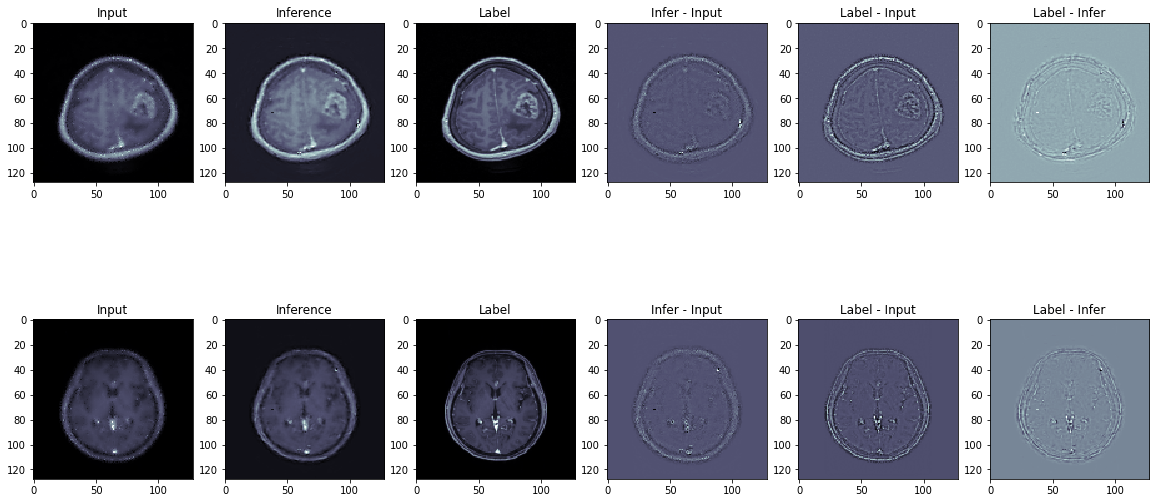

In [4]:
tr_batch_seq = np.random.choice(len(tr_idx), 1, replace=False)
test_tr = deblur.predict(tr_img[[tr_batch_seq[0]]])
te_batch_seq = np.random.choice(len(te_img), 1, replace=False)
test_te = deblur.predict(te_img[[te_batch_seq]])
plt.figure(figsize=(20, 10))

plt.subplot(2,6,1)
plt.title("Input")
plt.imshow(tr_img[tr_batch_seq[0],:,:,0], cmap=plt.cm.bone)
plt.subplot(2,6,2)
plt.title("Inference")
plt.imshow(test_tr[0], cmap=plt.cm.bone)
plt.subplot(2,6,3)
plt.title("Label")
plt.imshow(tr_lab[tr_batch_seq[0]], cmap=plt.cm.bone)
plt.subplot(2,6,4)
plt.title("Infer - Input")
plt.imshow(test_tr[0] - tr_img[tr_batch_seq[0],:,:,0], cmap=plt.cm.bone)
plt.subplot(2,6,5)
plt.title("Label - Input")
plt.imshow(tr_lab[tr_batch_seq[0]] - tr_img[tr_batch_seq[0],:,:,0], cmap=plt.cm.bone)
plt.subplot(2,6,6)
plt.title("Label - Infer")
plt.imshow(tr_lab[tr_batch_seq[0]] - test_tr[0], cmap=plt.cm.bone)

plt.subplot(2,6,7)
plt.title("Input")
plt.imshow(te_img[te_batch_seq[0],:,:,0], cmap=plt.cm.bone)
plt.subplot(2,6,8)
plt.title("Inference")
plt.imshow(test_te[0], cmap=plt.cm.bone)
plt.subplot(2,6,9)
plt.title("Label")
plt.imshow(te_lab[te_batch_seq[0]], cmap=plt.cm.bone)
plt.subplot(2,6,10)
plt.title("Infer - Input")
plt.imshow(test_te[0] - te_img[te_batch_seq[0],:,:,0], cmap=plt.cm.bone)
plt.subplot(2,6,11)
plt.title("Label - Input")
plt.imshow(te_lab[te_batch_seq[0]] - te_img[te_batch_seq[0],:,:,0], cmap=plt.cm.bone)
plt.subplot(2,6,12)
plt.title("Label - Infer")
plt.imshow(te_lab[te_batch_seq[0]] - test_te[0], cmap=plt.cm.bone)

plt.show()